# Quick start
 
For example, we  use the spatial expression matrix of Bin1 of Stereo-Seq in the mouse olfactory bulb for the use of **stereopy** tools for downstream analysis.

There are two types of Stereo-seq data, gem and gef. The format of the original expression matrix of gem file is as follows: x, y are the spatial position of the gene in the tissue section, and count is the number of gene expression.

|  GeneID   | x | y | count |
|  ----  | ----  | ----| ----|
| Gene1  | 121 | 200 | 2 |
| Gene2  | 234 | 300 | 1 |
| ...  | ... | ... | ... |
| Gene n | 234 | 300 | 1 |

The detail information of gef file is in the [documentation](https://www.processon.com/view/link/610cc49c7d9c087bbd1ab7ab#map).Here, we recommend using the format of gef, the reading speed is much faster than gem.

## Read the raw data of Stereo-Seq

The resolution of Stereo-Seq sequencing technology is up to nanometer level. The nanopore radius of Bin1 is 250 nm. 

Generally, the **bin_size** parameter is set to combine the nanopores within a certain range into a bin unit for analysis. tthe side length of the bin unit is approximately 14 microns when **bin_size** is set to 20.

After merging according to a certain **bin_size**, we will uniformly generate the data into the format of StereoExpData, which is designed for the analysis.

In addition, stereopy can support reading 10x data, as detailed in the API documentation.

In [43]:
import warnings

warnings.filterwarnings('ignore')
import stereo as st

!mkdir stereo_demo
!cd stereo_demo
!git clone https://github.com/BGIResearch/stereopy_data.git
!cd stereopy_data/mouse

In [44]:
mouse_data_path = '/ldfssz1/ST_BI/USER/huangzhibo/workitems/DP8400013846TR_F5_out_new/stereomics.h5'
data = st.io.read_gef(file_path=mouse_data_path, bin_size=50)

2021-12-03 10:47:40 Stereo INFO: read_gef begin ...
2021-12-03 10:47:41 Stereo INFO: the martrix has 13129 cells, and 28553 genes.
2021-12-03 10:47:42 Stereo INFO: read_gef end.


## Preprocessing

Data preprocessing includes three modules: **Quality control**, **Filtering** and **Normalization**.

### Quality control

The quality control module mainly calculates the data quality distribution of the original data, and mainly counts three indicators:
- the number of genes expressed in the count matrix. (n_genes_by_counts)
- the total counts per cell. (total_counts)
- the percentage of counts in mitochondrial genes. (pct_counts_mt)

In [45]:
data.tl.cal_qc()

Show the violin figure of the qc distribution.

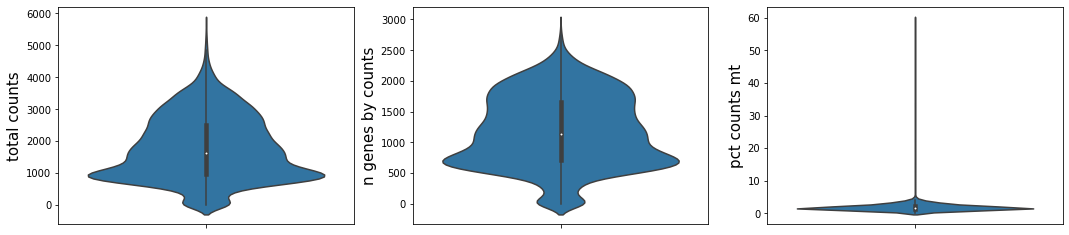

In [46]:
data.plt.violin()

Show the spatial scatter figure of the qc distribution.

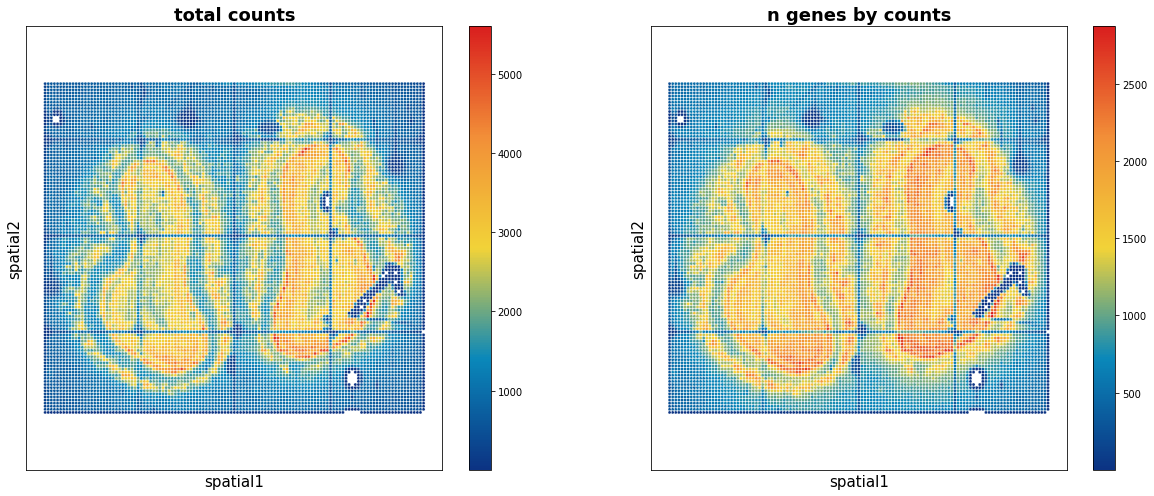

In [47]:
data.plt.spatial_scatter()

### Filtering

Generally, we will filter the `bin unit` based on the three quality control indicators total_count, n_genes_by_counts and pct_counts_MT.

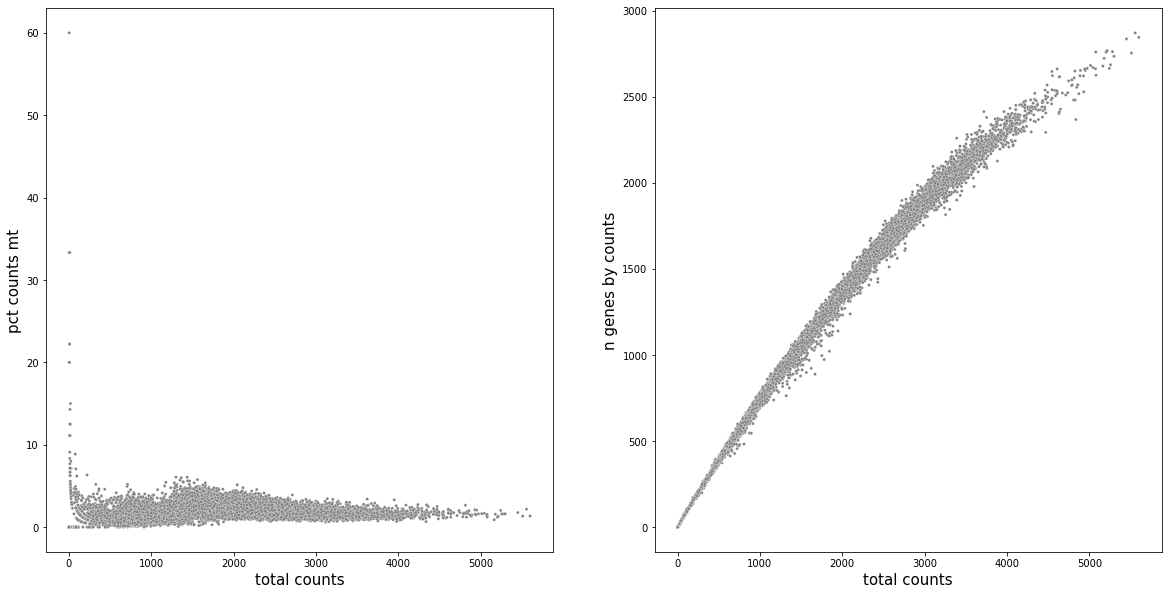

In [48]:
data.plt.genes_count()

In [49]:
data.tl.filter_cells(min_gene=200, min_n_genes_by_counts=3, max_n_genes_by_counts=2500, pct_counts_mt=5, inplace=True)

In addition, we also provide `data.tl.filter_genes` function to filter genes and `data.tl.filter_coordinates` function to filer bin unit by its coordinate.

For detailed instructions, please refer to its api document.

In [50]:
data.tl.highly_variable_genes(min_mean=0.0125, max_mean=3,min_disp=0.5,
                              n_top_genes=2000, res_key='raw_highly_variable_genes')
                              

We use raw data to find hvg, and this set of hvg will be used in `data.tl.spatial_hotspot`

### Normalization

In this module, we mainly provide four common standardization methods.

- normalize_total
- quantile
- zscore_disksmooth
- scTransform

If the parameter `inplace` is set to True, data.exp_matrix will be replaced with the normalized result, otherwise unchanged. You can save the raw exp_matrix by `data.tl.raw_checkpoint()`.

In [51]:
data.tl.raw_checkpoint()

Run the scTransform normalization method.You can set the `res_key` for save the result. the express matrix will be replaceed by the sctranform result if `inplace` is True.

In [52]:
data.tl.sctransform(res_key='sctransform', inplace=True)

 In addition, we also provide `data.tl.normalize_total`, `data.tl.quantile`, `data.tl.zscore_disksmooth` function for normalization.

## PCA

By default, PCA is used to reduce dimensionality. 

In [53]:
data.tl.pca(use_highly_genes=False, n_pcs=30, res_key='pca')

## Neighborhood graph

After PCA, we compute the neighborhood graph of cells using the PCA representation of the expression matrix. 

In [54]:
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors')

Besides, after `data.tl.neighbors`, if you want to add spatial information to recompute the neighborhood graph, you can use `data.tl.spatial_neighbors`. 
In this function we provide another pacakage "squidpy" to build a new adjacency matrix using position information and combine it with the result from `data.tl.neighbors` to do the calculation for a new adjacency matrix. 
The output of `data.tl.spatial_neighbors` can be used in the clustering.

Embedding the graph in two dimensions using UMAP.

In [55]:
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap')

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


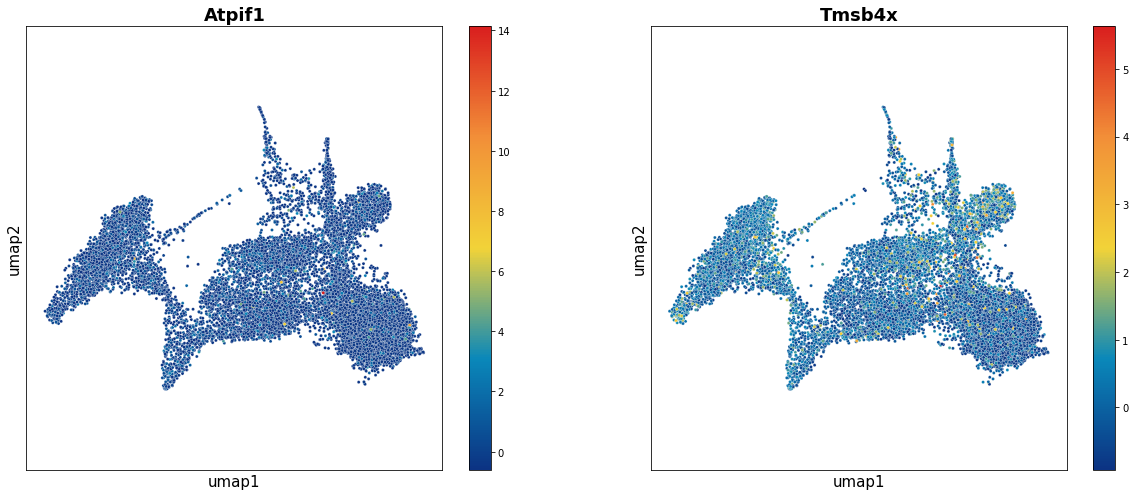

In [56]:
fig = data.plt.umap(gene_names=['Atpif1', 'Tmsb4x'], res_key='umap')

## Clustering

Currently we provide three common clustering methods, including **phenograph**, **leiden** and **louvain**. 

In this tool, you can re-run the normalization method before clustering if the `normalize_method` parameter is not None. Then by default, we use pca to reduce the dimensionality of the new normalization method, and then using the top 30 pcs to run clustering.

### leiden

In [57]:
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

Show the spatial distribution of the clusering result.

<AxesSubplot:>

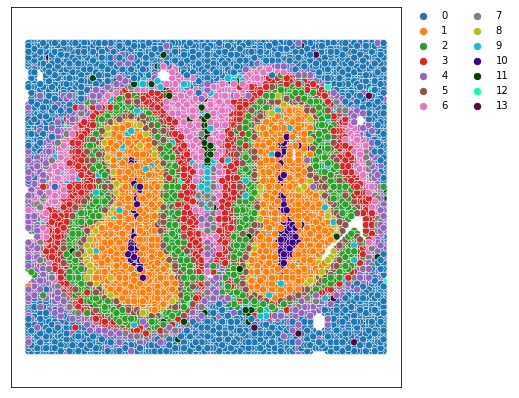

In [58]:
data.plt.cluster_scatter(res_key='leiden', colors='glasbey_category10', dot_size=50)

It can also show the umap spatial distribution of the clustering result.

<AxesSubplot:title={'center':'leiden'}, xlabel='umap1', ylabel='umap2'>

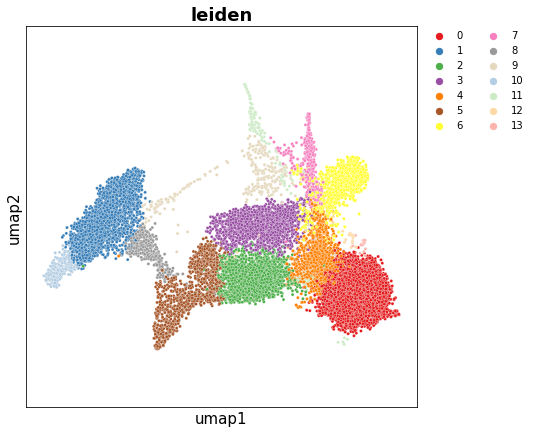

In [59]:
data.plt.umap(res_key='umap', cluster_key='leiden')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
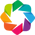

Row
    [0] ParamFunction(function)
    [1] Column
        [0] ColorPicker(name='background color', value='#ffffff', width=200)
        [1] IntSlider(end=200, name='dot size', start=1, value=7, width=200)
        [2] Select(name='color theme', options=['glasbey', 'glasbey_bw', ...], value='stereo_30', width=200)
        [3] Row
            [0] Select(name='cluster', options=['0', '1', '2', ...], value='0', width=100)
            [1] ColorPicker(name='node color', value='#E41A1C', width=70)

In [60]:
data.plt.interact_cluster(res_key='leiden')

This web page was generated from a Jupyter notebook and not all interactivity will work on this website. Right click to download and run locally for full Python-backed interactivity.

### louvain

In [61]:
data.tl.louvain(neighbors_res_key='neighbors', res_key='louvain')

2021-12-03 10:51:44 Stereo INFO:     using the "louvain" package of Traag (2017)


<AxesSubplot:>

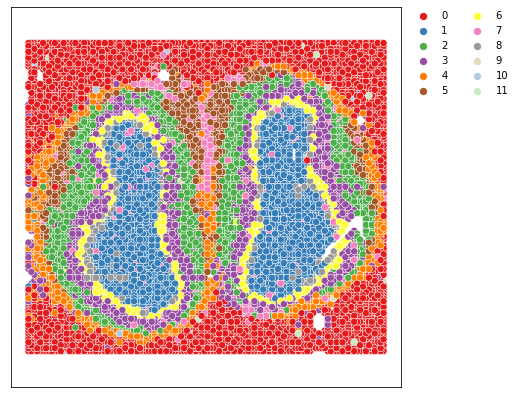

In [62]:
data.plt.cluster_scatter(res_key='louvain', dot_size=50)

### phenograph

In [63]:
data.tl.phenograph(phenograph_k=30, pca_res_key='pca', res_key='phenograph')

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 12.66469120979309 seconds
Jaccard graph constructed in 14.81741738319397 seconds
Running Leiden optimization
Leiden completed in 0.8485949039459229 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 42.28946018218994 seconds


<AxesSubplot:>

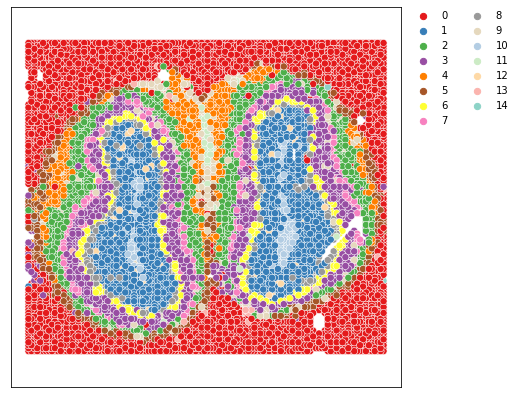

In [64]:
data.plt.cluster_scatter(res_key='phenograph', dot_size=50)

## Find marker genes

By default, the raw count of express matrix and highly-variable genes are used to compute the result.

### Hypothesis test
In `st.tools.FindMarker`, it provides a hypothesis test to analyze differences between two groups. It support two methods including `t_test` and `wilcoxon_test`.

In [65]:
data.tl.find_marker_genes(cluster_res_key='leiden', method='t_test', use_highly_genes=False, use_raw=True)

2021-12-03 10:52:29 Stereo INFO: read group information, grouping by group column.
2021-12-03 10:52:29 Stereo INFO: start to run...
Find marker gene:   0%|          | 0/14 [00:00<?, ?it/s]2021-12-03 10:52:30 Stereo INFO: start to select group
2021-12-03 10:52:30 Stereo INFO: end selelct group
2021-12-03 10:52:34 Stereo INFO: 12
Find marker gene:   7%|▋         | 1/14 [00:04<00:57,  4.42s/it]2021-12-03 10:52:34 Stereo INFO: start to select group
2021-12-03 10:52:36 Stereo INFO: end selelct group
2021-12-03 10:52:38 Stereo INFO: 3
Find marker gene:  14%|█▍        | 2/14 [00:08<00:49,  4.11s/it]2021-12-03 10:52:38 Stereo INFO: start to select group
2021-12-03 10:52:39 Stereo INFO: end selelct group
2021-12-03 10:52:42 Stereo INFO: 10
Find marker gene:  21%|██▏       | 3/14 [00:11<00:42,  3.86s/it]2021-12-03 10:52:42 Stereo INFO: start to select group
2021-12-03 10:52:43 Stereo INFO: end selelct group
2021-12-03 10:52:45 Stereo INFO: 9
Find marker gene:  29%|██▊       | 4/14 [00:15<00:37, 

Then, show the score of top 10 marker genes for the each group.

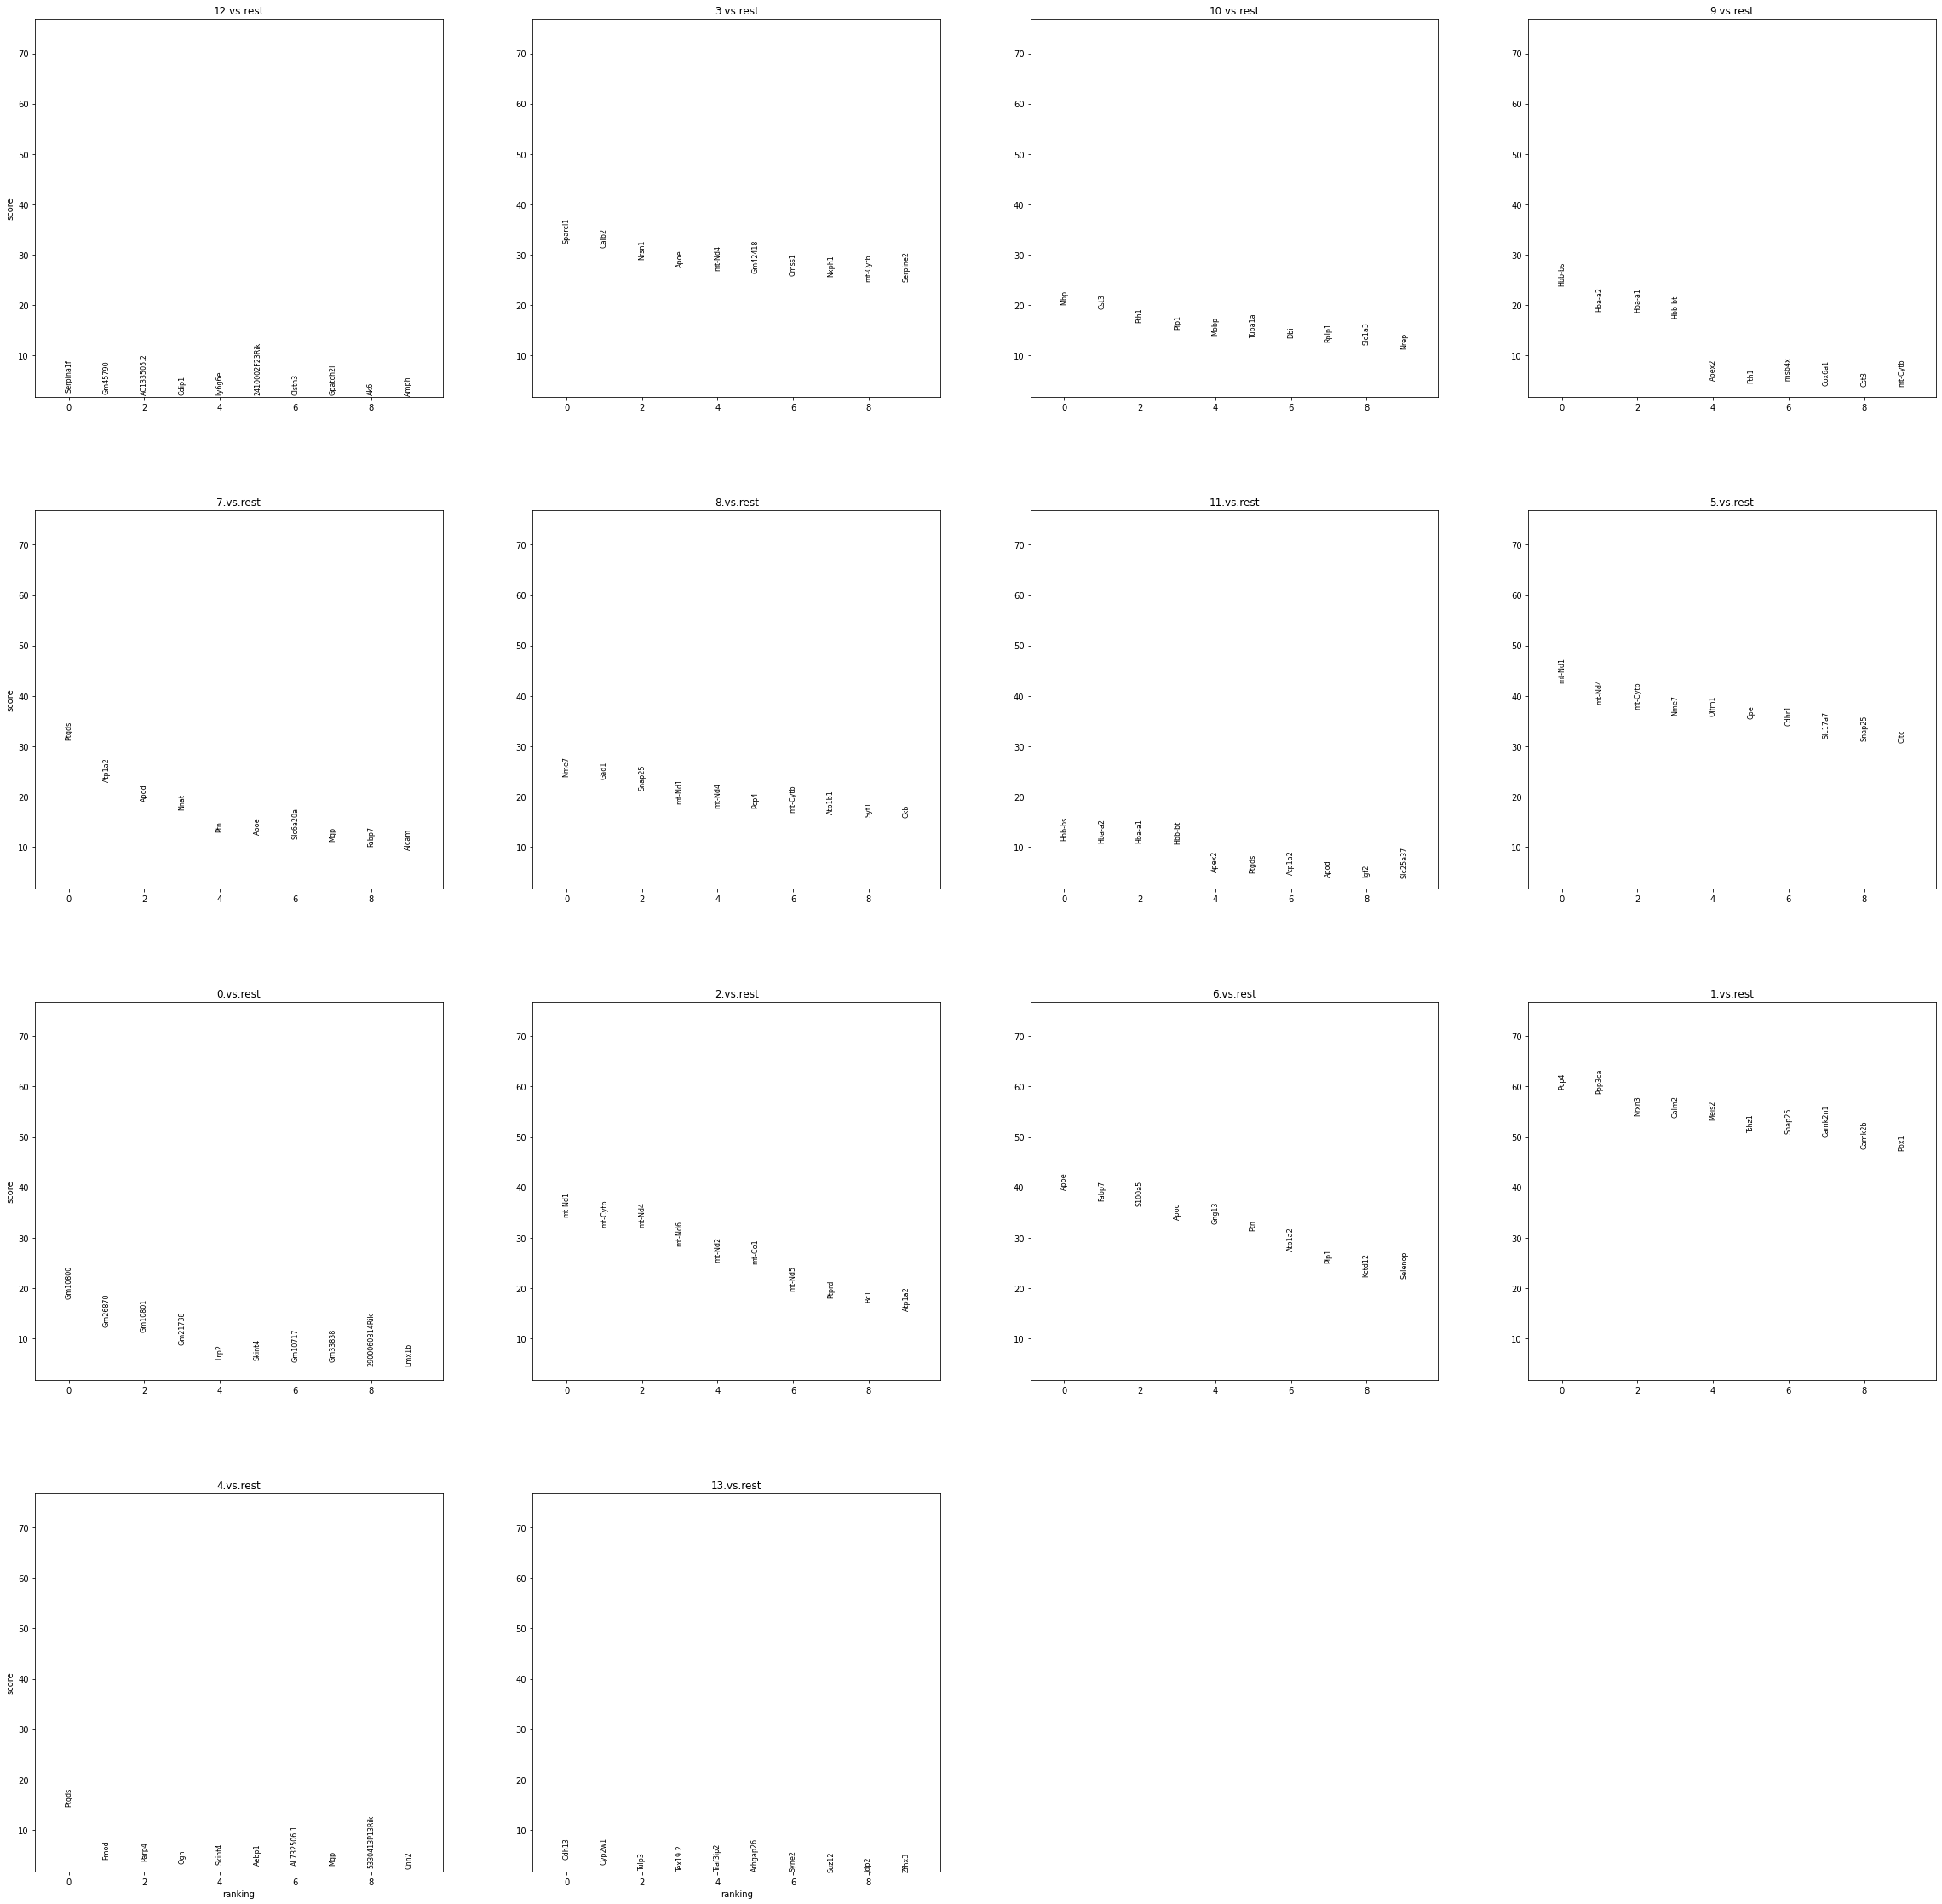

In [66]:
data.plt.marker_genes_text(res_key='marker_genes', markers_num=10, sort_key='scores')

Show the heatmap plot of top 5 marker genes.

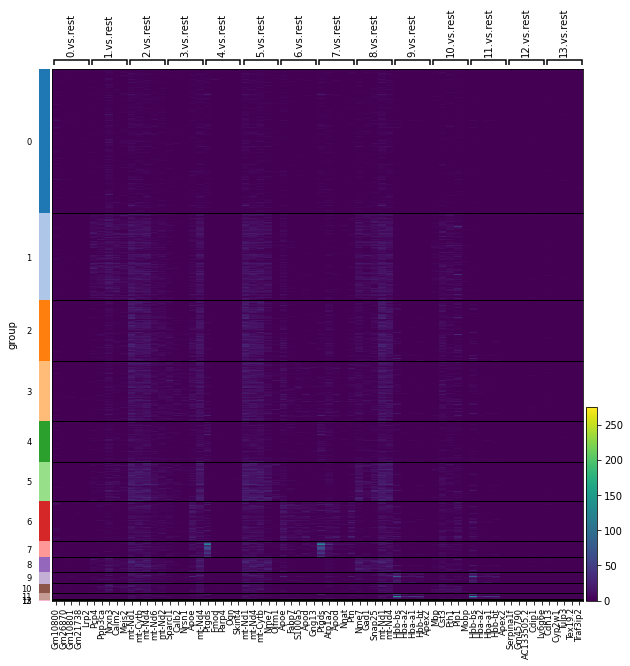

In [67]:
data.plt.marker_genes_heatmap(res_key='marker_genes', cluster_res_key='leiden', do_log=False)

Show the volcano plot.

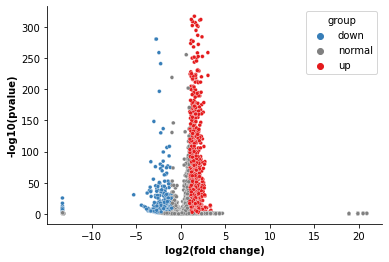

In [68]:
data.plt.marker_gene_volcano(group_name='1.vs.rest', vlines=False)

## Hotspot

Hotspot is a tool for identifying informative genes (and gene modules) in a single-cell dataset.

Importantly ‘informative’ is decided based on how well a gene’s variation agrees with some cell metric - some similarity mapping between cells.

Genes which are informative are those whose expression varies in similar way among cells which are nearby in the given metric.

In [72]:
data.tl.spatial_hotspot(use_highly_genes=True, use_raw=True, hvg_res_key="raw_highly_variable_genes", 
                        model='normal', n_neighbors=30,n_jobs=20, fdr_threshold=0.05, min_gene_threshold=50, 
                        res_key='spatial_hotspot')


100%|██████████| 2000/2000 [01:00<00:00, 33.21it/s]


Computing pair-wise local correlation on 313 features...


100%|██████████| 48828/48828 [00:04<00:00, 10530.13it/s]


Computing scores for 3 modules...


100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


A convenience method is supplied to plot the results of hs.create_modules

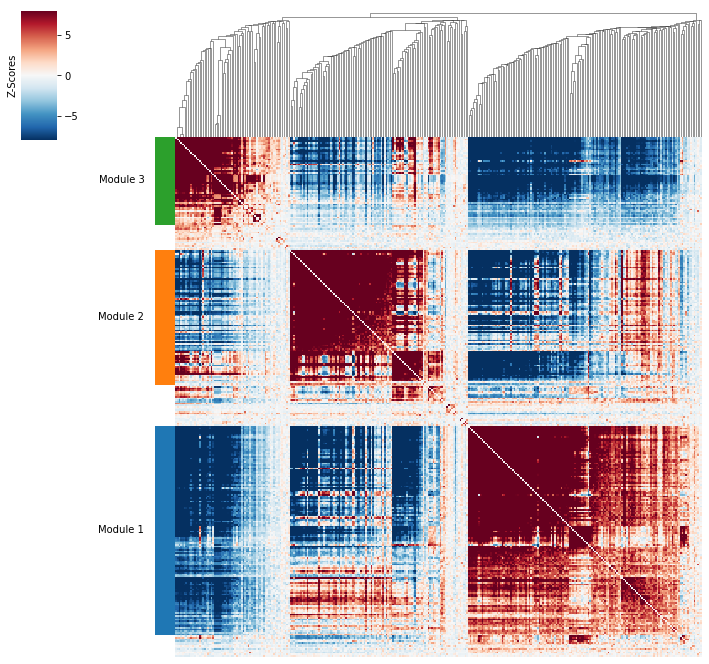

In [75]:
data.plt.hotspot_local_correlations()


Here we can visualize these module scores with spatial position.

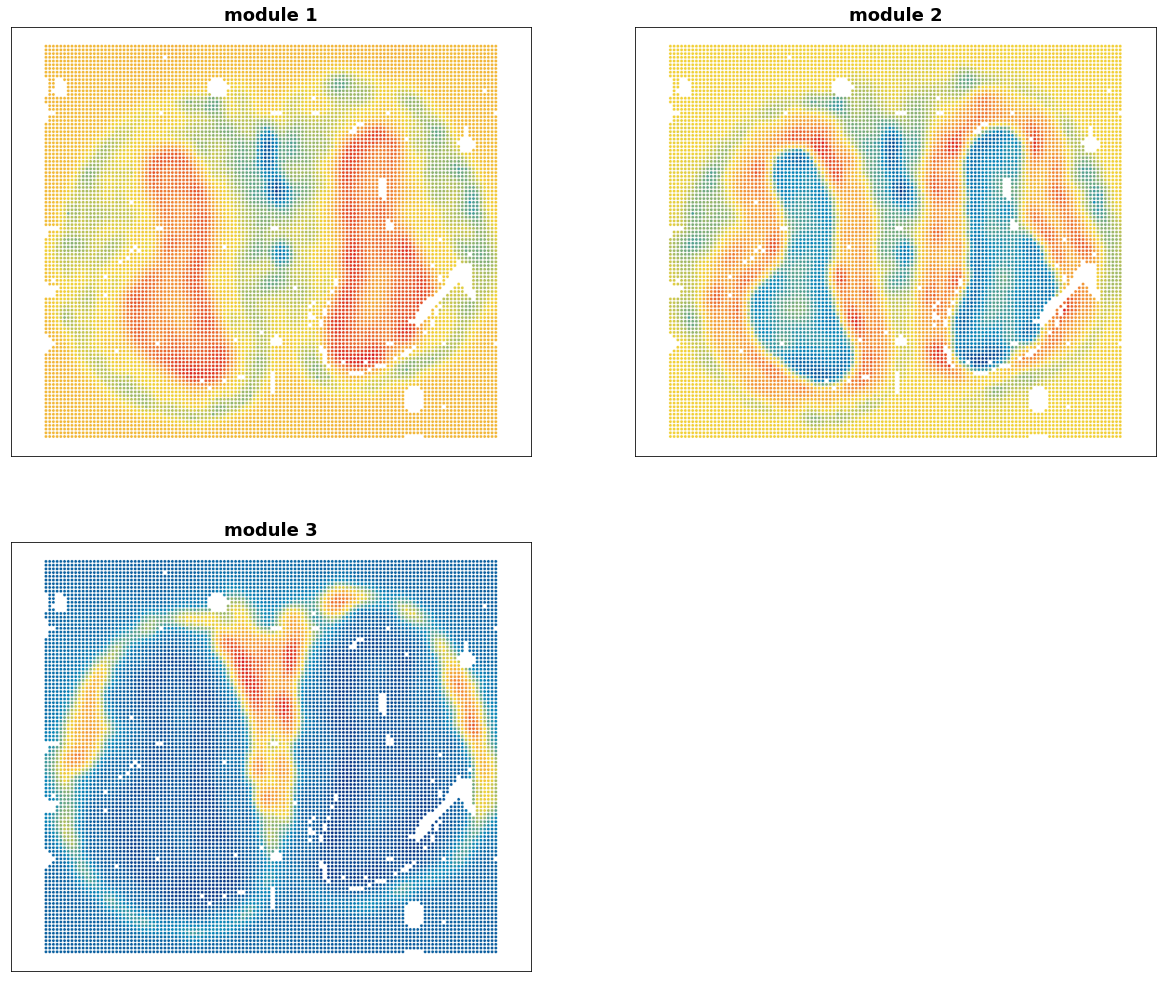

In [74]:
data.plt.hotspot_modules()